# PHISHING EMAIL DETECTOR USING NEURAL NETWORKS

This notebook compares **three variants of Neural Networks** and compares their result. The models used here for comparison are **RNN, ANN, LSTM, Bi-LSTM**. A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In this sense, neural networks refer to systems of neurons, either organic or artificial in nature.

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Importing Data and Preprocessing**

In [ ]:
data1 = pd.read_csv('/spam_ham_dataset.csv')
data2 = pd.read_csv("/SMS_train.csv", encoding='cp1252')

FileNotFoundError: ignored

In [ ]:
data1 = data1.drop(['Unnamed: 0', 'label'], axis=1)
data1 = data1.rename(columns = {"label_num" : "Label"})

In [ ]:
data2 = data2.drop(["S. No."], axis = 1)
data2 = data2.rename(columns = {"Message_body" : "text"})
data2["Label"] = [1 if i == "Spam" else 0 for i in data2["Label"]]

In [ ]:
frames = [data1, data2]
data = pd.concat(frames)
data

,text,Label
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...
952,hows my favourite person today? r u workin har...,0
953,How much you got for cleaning,0
954,Sorry da. I gone mad so many pending works wha...,0
955,Wat time ü finish?,0


Visualization

Text(0.5, 1.0, 'Spam Word Cloud')

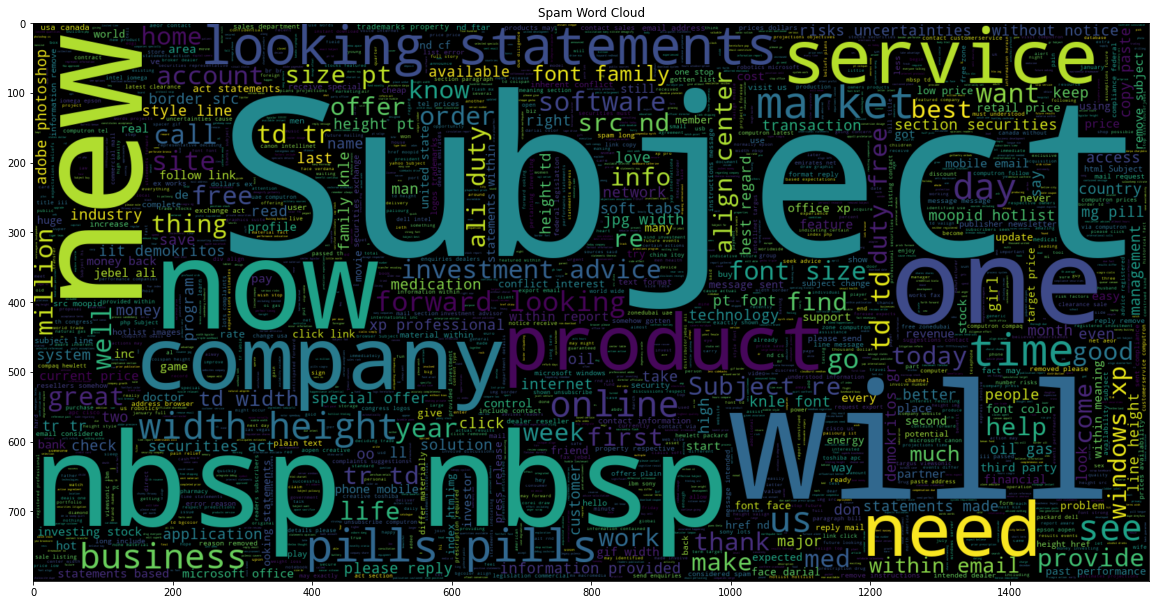

In [ ]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.Label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Spam Word Cloud")

Text(0.5, 1.0, 'Ham Word Cloud')

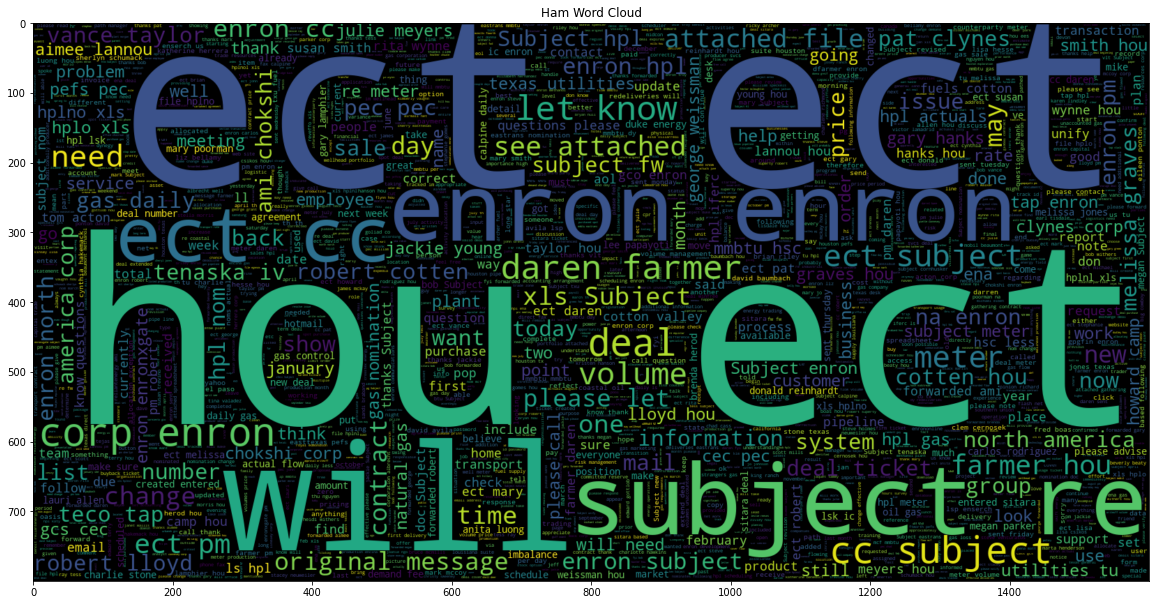

In [ ]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.Label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.title("Ham Word Cloud")

Stemming and Tokenizer

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S+|[^A-Za-z0-9]:\S+|subject:\S+|nbsp"

In [ ]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

data.text = data.text.apply(lambda x: preprocess(x))
data.head()

,text,Label
0,subject: enron methanol ; meter # : 988291 fol...,0
1,"subject: hpl nom january 9 , 2001 ( see attach...",0
2,"subject: neon retreat ho ho ho , ' around wond...",0
3,"subject: photoshop , windows , office . cheap ...",1
4,subject: : indian springs deal book teco pvr r...,0


In [ ]:
x = data['text']
y = data['Label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                         random_state=7)
print("Train Data size:", len(x_train))
print("Test Data size", len(x_test))

Train Data size: 4902
Test Data size 1226


In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1000
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 45043


In [ ]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(x_train),
                        maxlen = 50)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test),
                       maxlen = 50)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

**ANN**
*Artificial neural network (ANN) is a computational model that consists of several processing elements that receive inputs and deliver outputs based on their predefined activation functions.*

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
ann = Sequential()
ann.add(Dense(16, activation='relu', input_dim=50))
# Adding dropout to prevent overfitting
ann.add(Dropout(0.1))
ann.add(Dense(1, activation='sigmoid'))

In [ ]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                816       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = ann.fit(x_train, y_train,
                  batch_size=10,
                  epochs=100,
                  verbose=2,
                  validation_data=(x_test, y_test))

Epoch 1/100
491/491 - 2s - loss: 841.6006 - accuracy: 0.5483 - val_loss: 255.9875 - val_accuracy: 0.6003 - 2s/epoch - 4ms/step
Epoch 2/100
491/491 - 1s - loss: 209.7687 - accuracy: 0.5953 - val_loss: 86.4151 - val_accuracy: 0.6542 - 746ms/epoch - 2ms/step
Epoch 3/100
491/491 - 1s - loss: 64.5904 - accuracy: 0.6361 - val_loss: 29.2171 - val_accuracy: 0.7055 - 725ms/epoch - 1ms/step
Epoch 4/100
491/491 - 1s - loss: 23.2381 - accuracy: 0.6659 - val_loss: 14.3897 - val_accuracy: 0.6330 - 761ms/epoch - 2ms/step
Epoch 5/100
491/491 - 1s - loss: 10.3732 - accuracy: 0.6669 - val_loss: 9.1173 - val_accuracy: 0.6623 - 743ms/epoch - 2ms/step
Epoch 6/100
491/491 - 1s - loss: 6.7468 - accuracy: 0.6746 - val_loss: 6.2169 - val_accuracy: 0.7137 - 734ms/epoch - 1ms/step
Epoch 7/100
491/491 - 1s - loss: 3.5088 - accuracy: 0.6873 - val_loss: 4.8395 - val_accuracy: 0.7537 - 696ms/epoch - 1ms/step
Epoch 8/100
491/491 - 1s - loss: 2.5802 - accuracy: 0.6938 - val_loss: 4.5944 - val_accuracy: 0.6998 - 757ms/

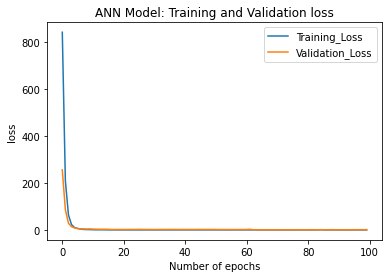

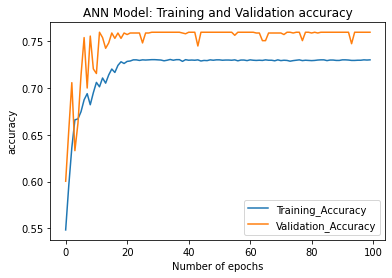

In [ ]:
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('ANN Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
y_pred = ann.predict(x_test)
y_pred = (y_pred > 0.5)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
cm

array([[931,   0],
       [295,   0]])

In [ ]:
print("Our accuracy is %{}".format(((cm[0][0] + cm[1][1])/1035)*100))

Our accuracy is %89.95169082125604


**RNN**
*A recurrent neural network (RNN) is a type of artificial neural network which uses sequential data or time series data.*

In [ ]:
from keras.layers import SimpleRNN
rnn = Sequential()
rnn.add(SimpleRNN(128, activation='relu', input_dim=50 , return_sequences = True))
rnn.add(SimpleRNN(64, activation='relu' ,  return_sequences = False))
# Adding dropout to prevent overfitting
#rnn.add(Dropout(0.1))
rnn.add(Dense(1, activation='sigmoid'))

In [ ]:
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 128)         22912     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 35,329
Trainable params: 35,329
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
print(x_train.shape)
print(y_train.shape)

(4902, 50)
(4902,)


In [ ]:
print(x_test.shape)
print(y_test.shape)

(1226, 50)
(1226,)


In [ ]:
x_train1 = x_train.reshape(4902,1,50)
y_train1 = np.array(y_train).reshape(4902,1,1)

In [ ]:
x_test1 = x_test.reshape(1226,1,50)
y_test1 = np.array(y_test).reshape(1226,1,1)

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience=60)

history = rnn.fit(x_train1, y_train1,
                  batch_size=100,
                  epochs=100,
                  verbose=2,
                  callbacks=[early_stop],
                  validation_data=(x_test1, y_test1))

Epoch 1/100
50/50 - 2s - loss: 404.6208 - accuracy: 0.6302 - val_loss: 207.2538 - val_accuracy: 0.6036 - 2s/epoch - 44ms/step
Epoch 2/100
50/50 - 0s - loss: 173.5365 - accuracy: 0.6791 - val_loss: 153.7326 - val_accuracy: 0.7186 - 225ms/epoch - 5ms/step
Epoch 3/100
50/50 - 0s - loss: 101.6945 - accuracy: 0.7073 - val_loss: 125.8855 - val_accuracy: 0.7039 - 246ms/epoch - 5ms/step
Epoch 4/100
50/50 - 0s - loss: 76.1827 - accuracy: 0.7260 - val_loss: 109.7451 - val_accuracy: 0.6974 - 244ms/epoch - 5ms/step
Epoch 5/100
50/50 - 0s - loss: 47.9778 - accuracy: 0.7676 - val_loss: 106.0759 - val_accuracy: 0.7129 - 223ms/epoch - 4ms/step
Epoch 6/100
50/50 - 0s - loss: 37.4768 - accuracy: 0.7817 - val_loss: 108.1399 - val_accuracy: 0.7268 - 222ms/epoch - 4ms/step
Epoch 7/100
50/50 - 0s - loss: 29.6133 - accuracy: 0.7980 - val_loss: 113.4761 - val_accuracy: 0.7504 - 185ms/epoch - 4ms/step
Epoch 8/100
50/50 - 0s - loss: 24.1441 - accuracy: 0.8113 - val_loss: 96.4817 - val_accuracy: 0.6354 - 201ms/e

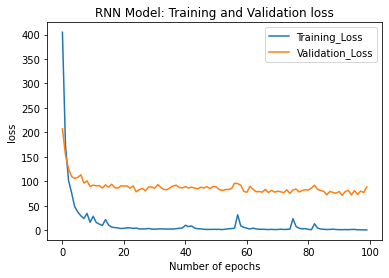

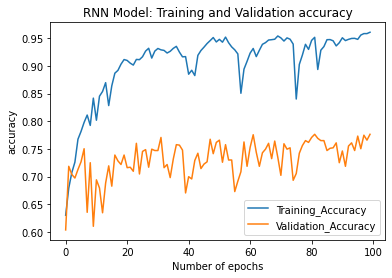

In [ ]:
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('RNN Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
trainPredict = rnn.predict(x_train1)
testPredict= rnn.predict(x_test1)

predicted=np.concatenate((trainPredict,testPredict),axis=0)

In [ ]:
trainScore = rnn.evaluate(x_train1, y_train1, verbose=0)
print("Our accuracy is %{}".format(trainScore[1]*100))

Our accuracy is %96.18523120880127


**LSTM**
*Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning.*

In [ ]:
MAX_SEQUENCE_LENGTH = 50
n_lstm = 200
drop_lstm =0.2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional, GRU

In [ ]:
embeding_dim = 16
drop_value = 0.2
n_dense = 24
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)

#LSTM Spam detection architecture
lstm = Sequential()
lstm.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
lstm.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
lstm.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
lstm.add(Dense(1, activation='sigmoid'))

In [ ]:
lstm.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history = lstm.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=num_epochs, verbose=2, callbacks=[early_stop])

Epoch 1/30
154/154 - 46s - loss: 0.4097 - accuracy: 0.8254 - val_loss: 0.2791 - val_accuracy: 0.8930 - 46s/epoch - 301ms/step
Epoch 2/30
154/154 - 41s - loss: 0.2270 - accuracy: 0.9109 - val_loss: 0.2605 - val_accuracy: 0.9010 - 41s/epoch - 264ms/step
Epoch 3/30
154/154 - 41s - loss: 0.1971 - accuracy: 0.9225 - val_loss: 0.2828 - val_accuracy: 0.8977 - 41s/epoch - 264ms/step
Epoch 4/30
154/154 - 40s - loss: 0.1852 - accuracy: 0.9261 - val_loss: 0.3073 - val_accuracy: 0.8998 - 40s/epoch - 263ms/step
Epoch 5/30
154/154 - 41s - loss: 0.1791 - accuracy: 0.9276 - val_loss: 0.3529 - val_accuracy: 0.8995 - 41s/epoch - 263ms/step
Epoch 6/30
154/154 - 40s - loss: 0.1750 - accuracy: 0.9286 - val_loss: 0.3325 - val_accuracy: 0.8999 - 40s/epoch - 261ms/step
Epoch 7/30
154/154 - 41s - loss: 0.1730 - accuracy: 0.9292 - val_loss: 0.4117 - val_accuracy: 0.8969 - 41s/epoch - 264ms/step


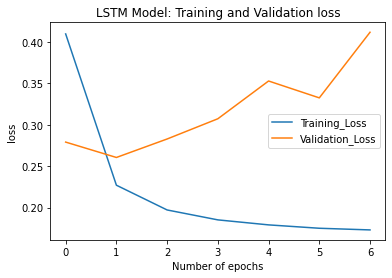

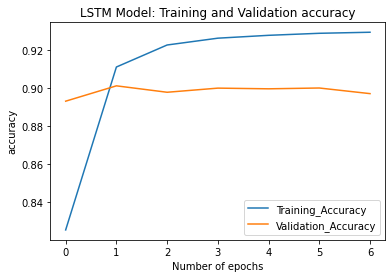

In [ ]:
metrics = pd.DataFrame(history.history)

metrics.rename(columns= {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, 
               inplace = True)

def plot_graphs(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

plot_graphs('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
# make predictions
trainPredict2 = lstm.predict(x_train, batch_size=256)
lstm.reset_states()
testPredict2 = lstm.predict(x_test, batch_size=256)

In [ ]:
predicted2=np.concatenate((trainPredict2,testPredict2),axis=0)

In [ ]:
trainScore2 = lstm.evaluate(x_train, y_train, verbose=0)
print("Our accuracy is %{}".format(trainScore2[1]*100))

Our accuracy is %92.99960732460022


**Bi-LSTM**
*Bidirectional long-short term memory(bi-lstm) is the process of making any neural network o have the sequence information in both directions backwards (future to past) or forward(past to future).*

In [ ]:
bi_lstm = Sequential()
bi_lstm.add(Embedding(vocab_size, embeding_dim, input_length=MAX_SEQUENCE_LENGTH))
bi_lstm.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
bi_lstm.add(Dense(1, activation='sigmoid'))

In [ ]:
bi_lstm.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)

history2 = bi_lstm.fit(x_train, y_train, epochs=num_epochs,
                    validation_data=(x_test, y_test),
                    callbacks =[early_stop], verbose=2)

Epoch 1/30
154/154 - 34s - loss: 0.3509 - accuracy: 0.8421 - val_loss: 0.1243 - val_accuracy: 0.9606 - 34s/epoch - 223ms/step
Epoch 2/30
154/154 - 29s - loss: 0.0771 - accuracy: 0.9824 - val_loss: 0.1335 - val_accuracy: 0.9623 - 29s/epoch - 189ms/step
Epoch 3/30
154/154 - 29s - loss: 0.0303 - accuracy: 0.9941 - val_loss: 0.1226 - val_accuracy: 0.9639 - 29s/epoch - 190ms/step
Epoch 4/30
154/154 - 29s - loss: 0.0121 - accuracy: 0.9980 - val_loss: 0.1603 - val_accuracy: 0.9650 - 29s/epoch - 192ms/step
Epoch 5/30
154/154 - 30s - loss: 0.0119 - accuracy: 0.9979 - val_loss: 0.1811 - val_accuracy: 0.9570 - 30s/epoch - 194ms/step


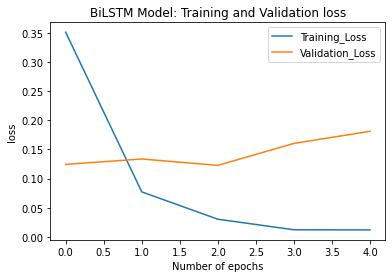

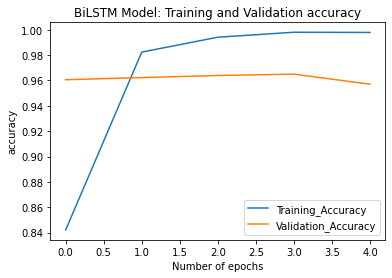

In [ ]:
metrics = pd.DataFrame(history2.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [ ]:
# make predictions
trainPredict3 = bi_lstm.predict(x_train, batch_size=256)
bi_lstm.reset_states()
testPredict3 = bi_lstm.predict(x_test, batch_size=256)

In [ ]:
predicted3=np.concatenate((trainPredict3,testPredict3),axis=0)

In [ ]:
trainScore3 = bi_lstm.evaluate(x_train, y_train, verbose=0)
print("Our accuracy is %{}".format(trainScore3[1]*100))

Our accuracy is %99.97265934944153
